We investigate the capability of the tracking module based on pairwise comparisons using known shapes and rotations. The method is to construct images with shapes in an array with known properties.

# Ellipse
The equation for an ellipse with area $\pi ab$ is $$\frac{x^2}{a} + \frac{y^2}{b} = 1$$
The eccentricity $e$ is calculated by 
$$e = \sqrt{1 - \frac{b^2}{a^2}}$$
We produce a gridded image with ellipses of a range of areas and eccentricities, from circles to oblong shapes. 

Equivalent circle radius will go from 5 pixels to 25 pixels. (Below small threshold to above large threshold). Eccentricity from 0 to 0.8 (not sure a best top value) in steps of 0.2. So we'll have 25 objects in each image.

Given an area $A$ and eccentricity $e$ we can solve for the major and minor axes $a$ and $b$ as
$$b = \sqrt{\frac{A\sqrt{1 - e^2}}{\pi}}$$
$$a = \frac{A}{\pi b}$$


In [1082]:
import numpy as np
import skimage

r = np.linspace(5, 30, 6)
A = np.pi*r**2
E = np.linspace(0, 0.9, 8)
AA, EE = np.meshgrid(A, E)
r

array([ 5., 10., 15., 20., 25., 30.])

In [1083]:
def get_semi_maj_minor(area, eccentricity):
    """Computes the semimajor and semiminor axis given
    the area and eccentricity"""
    
    b = np.sqrt(area*np.sqrt(1 - eccentricity**2)/np.pi)
    a = area/(np.pi*b)
    return a, b

### Compute the size needed for the image ###

# First get the margin based on the longest and largest ellipse
a, b = get_maj_minor(AA, EE)
max_ax = max(np.max(a), np.max(b))
margin = np.ceil(max_ax)
print(margin)
ncols = len(e)
nrows = len(r)

# Needs 2*margin between objects, 1*margin at edges
rdim = 2*margin*(nrows)
cdim = 2*margin*(ncols)

# Get center indices
ri = np.arange(margin, rdim-margin+1, 2*margin).astype(int)
ci = np.arange(margin, cdim-margin+1, 2*margin).astype(int)

46.0


In [1084]:
max_ax = max(np.max(a), np.max(b))
max_ax

45.43942786650219

In [1085]:
import proplot as pplt
images = []
angles = np.arange(0, 91, 1)
for angle in angles:
    theta = np.deg2rad(angle)
    name = 'ellipses_' + str(angle).zfill(3) + 'deg.png'
    im = np.zeros((int(rdim + 15), int(cdim + 15)))
    for i, col in enumerate(ci):
        for j, row in enumerate(ri):
            a, b = get_semi_maj_minor(AA[i, j], EE[i, j])
            
            im[skimage.draw.ellipse(r=row, c=col, r_radius=b, c_radius=a,
                                    rotation=theta)] = 255
    images.append(im)
    skimage.io.imsave('../data/synthetic_ellipse_images/' + name, im.astype('uint8'))

# Comparing tracker estimates with true values

For the ellipse test, we have true area and eccentricity in the AA and EE matrices. The true a, b can be obtained from the `get_maj_minor` function. And the true centers are indexed by ri, ci.

In [1028]:
import pandas as pd
import proplot as pplt
df_results = pd.read_csv("../data/ellipse_test_tracked.csv", parse_dates=['passtime'])
props = {}
for angle, im in zip(angles, images):
    props[angle] = pd.DataFrame(skimage.measure.regionprops_table(skimage.measure.label(im),
                                                          properties=['area', 'centroid', 'orientation', 'perimeter',
                                                                      'axis_major_length', 'axis_minor_length']))
    props[angle].rename({'centroid-0': 'row_centroid',
                     'centroid-1': 'col_centroid'}, axis=1, inplace=True)
    props[angle]['rotation'] = int(angle)
    props[angle]['eccentricity'] = np.sqrt(1 - (props[angle]['axis_minor_length']/props[angle]['axis_major_length'])**2)
    index = 0
    for index in props[angle].index:
        ii = np.argmin(np.abs(ri - props[angle].loc[index, ['row_centroid']].values))
        jj = np.argmin(np.abs(ci - props[angle].loc[index, ['col_centroid']].values))

        props[angle].loc[index, 'true_row_center'] = ri[ii]
        props[angle].loc[index, 'true_col_center'] = ci[jj]
        props[angle].loc[index, 'true_area'] = A[ii]
        props[angle].loc[index, 'true_ecc'] = E[jj]
        a, b = get_semi_maj_minor(A[ii], E[jj])
        props[angle].loc[index, 'true_axis_minor_length'] = 2*b
        props[angle].loc[index, 'true_axis_major_length'] = 2*a
    props[angle]['true_perimeter'] = props[0]['perimeter']

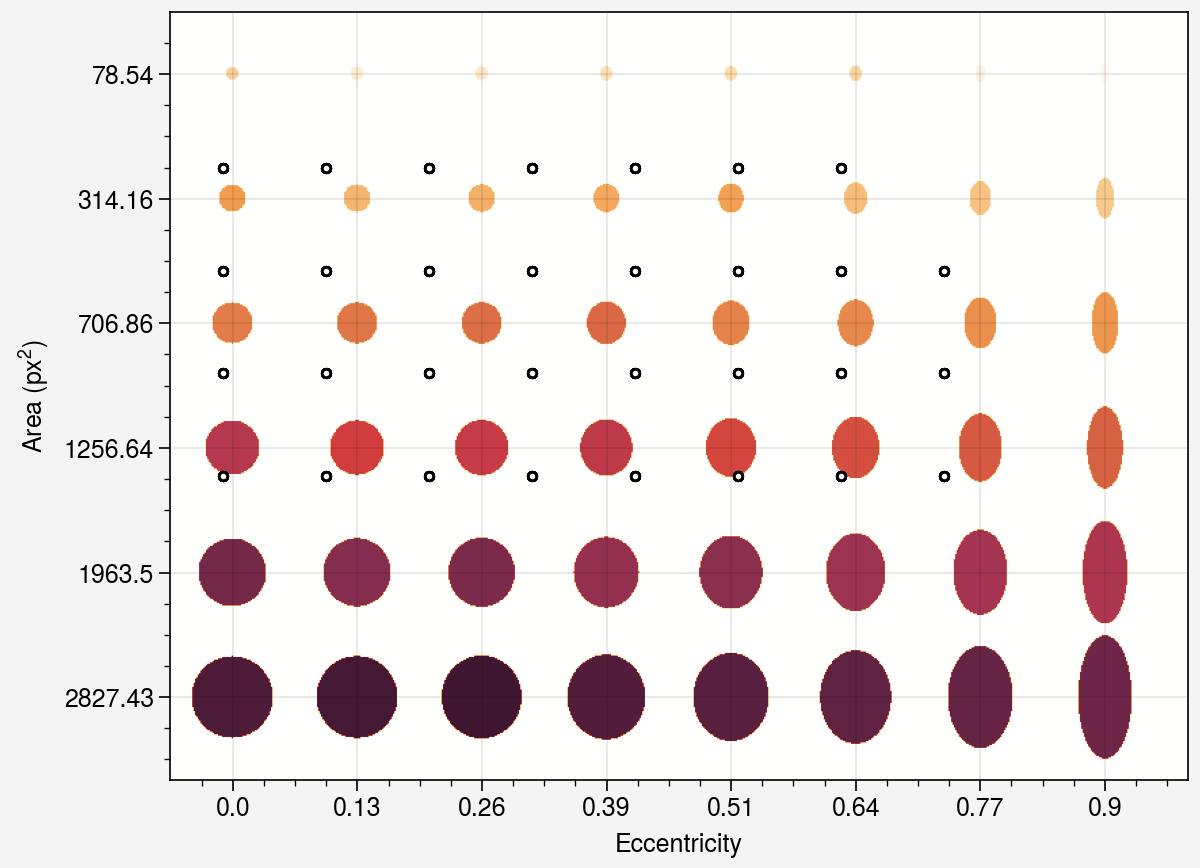

In [1086]:
# show again with the original image sizes...
medians = df_results.groupby("ID").median()
fig, ax = pplt.subplots(width=6)
ax.imshow(skimage.measure.label(im))
for row, data in df_results.iterrows():
    ax.plot(data.col_centroid, data.row_centroid, marker='.', color='w', edgecolor='k')
ax.format(ylim=(0, rdim + 15), xlim=(0, cdim + 15), yreverse=True, ylocator=ri, xlocator=ci,
         yformatter=[str(np.round(a, 2)) for a in A],
         xformatter=[str(np.round(e, 2)) for e in E],
         xlabel='Eccentricity', ylabel='Area (px$^2$)')

In the above, only floes with dots were tracked.

How much uncertainty is present due to orientation? We investigate as a function of area and of eccentricity.


In [1093]:
props_all = pd.concat(props, axis=0).reset_index(drop=True)
props_all['rel_err_area'] = (props_all['true_area'] - props_all['area'])/props_all['true_area']
props_all['rel_err_maj'] = (props_all['true_axis_major_length'] - props_all['axis_major_length'])/props_all['true_axis_major_length']
props_all['rel_err_min'] = (props_all['true_axis_minor_length'] - props_all['axis_major_length'])/props_all['true_axis_major_length']
props_all['rel_err_per'] = (props_all['true_perimeter'] - props_all['perimeter'])/props_all['true_perimeter']

results = props_all.groupby(['true_ecc', 'true_area']).std()

In [1088]:
results.columns

Index(['area', 'row_centroid', 'col_centroid', 'orientation', 'perimeter',
       'axis_major_length', 'axis_minor_length', 'rotation', 'eccentricity',
       'true_row_center', 'true_col_center', 'true_axis_minor_length',
       'true_axis_major_length', 'true_perimeter', 'rel_err_area',
       'rel_err_maj', 'rel_err_min', 'rel_err_per'],
      dtype='object')

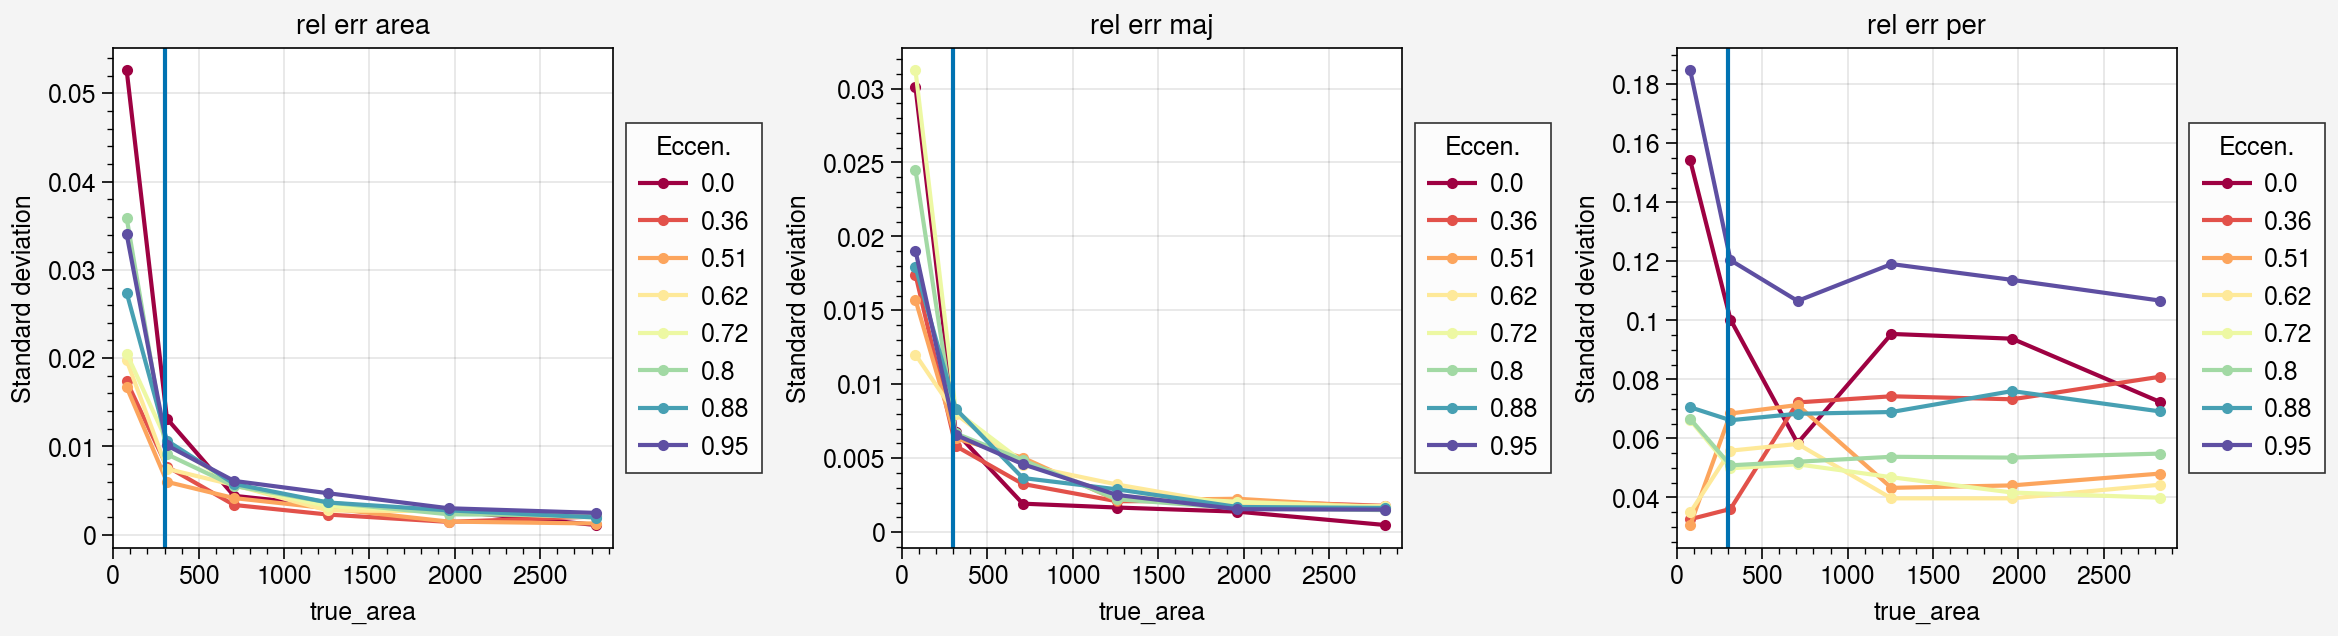

In [1089]:
plot_df = results.pivot_table(index='true_area', columns='true_ecc', values='area')
labels = [np.round(ecc, 2) for ecc in plot_df.columns]
colors = {ecc: c['color'] for ecc, c in zip(
            labels,
            pplt.Cycle('spectral', len(labels)))}

fig, axs = pplt.subplots(ncols=3, share=False)
for ax, col in zip(axs, ['rel_err_area', 'rel_err_maj', 'rel_err_per']):
    plot_df = results.pivot_table(index='true_area', columns='true_ecc', values=col)
    plot_df.columns = [np.round(ecc, 2) for ecc in plot_df.columns]
    for ecc in plot_df.columns: 
        ax.plot(plot_df.loc[:, ecc], marker='.', c=colors[ecc], label=ecc)
    ax.format(ylabel='Standard deviation',
              title=col.replace('_', ' '), xlim=(0, A.max()+100))
    ax.legend(ncols=1, title='Eccen.', loc='r')
    ax.axvline(300)

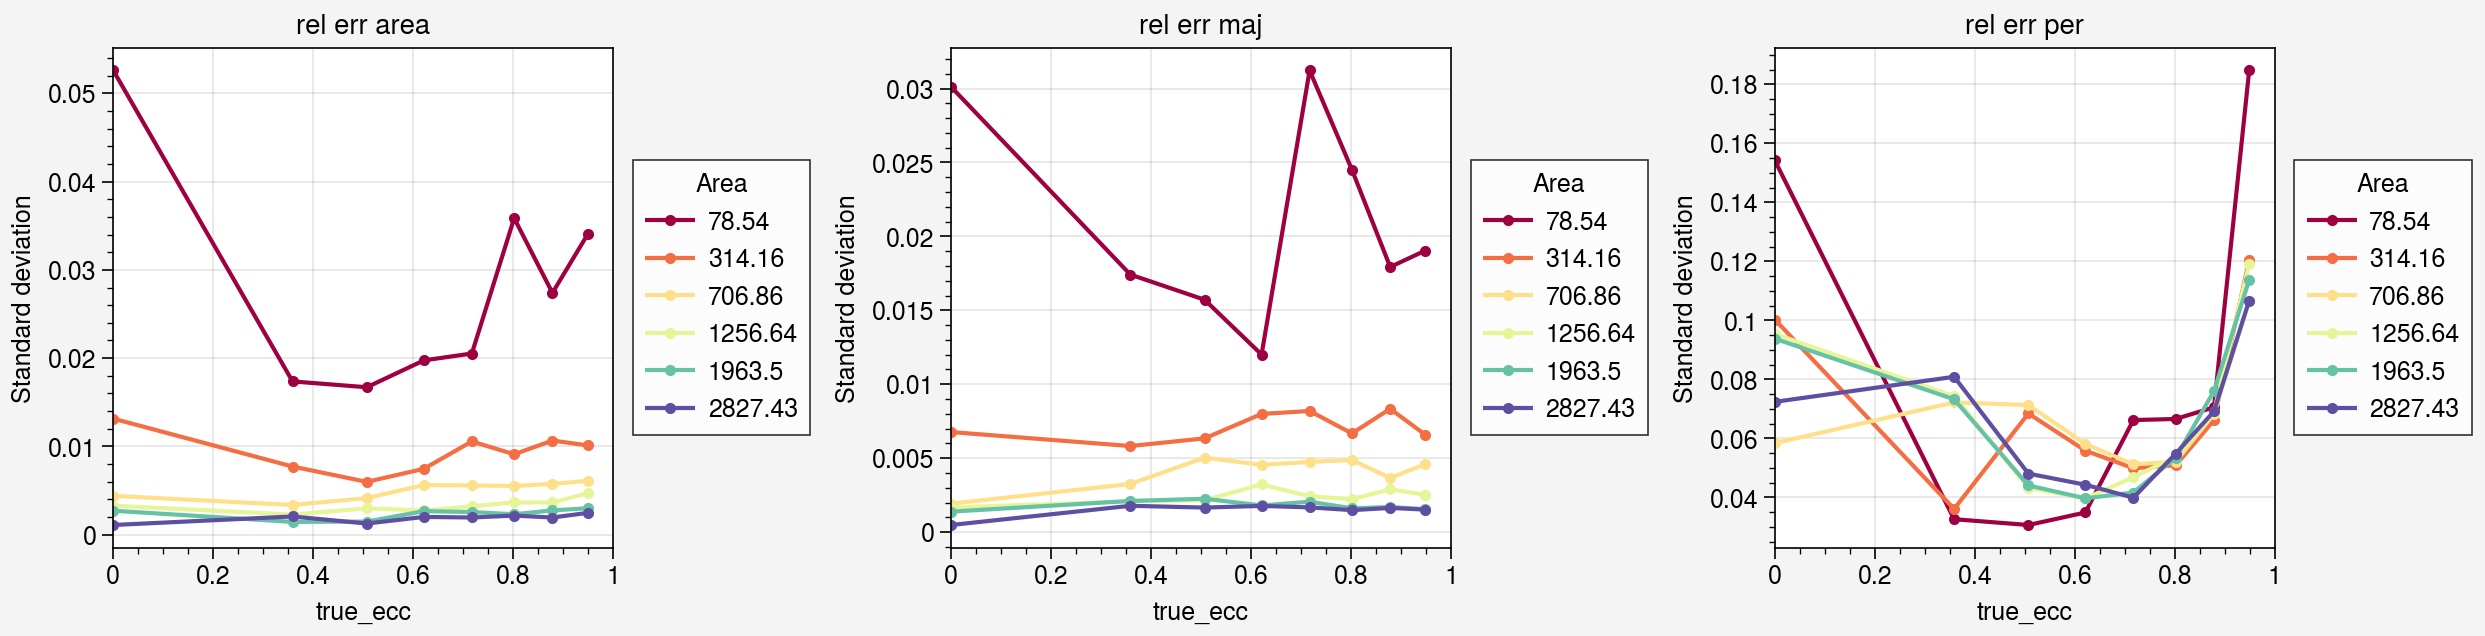

In [1090]:

results = props_all.groupby(['true_ecc', 'true_area']).std()

plot_df = results.pivot_table(index='true_ecc', columns='true_area', values='area')
labels = [np.round(ecc, 2) for ecc in plot_df.columns]
colors = {ecc: c['color'] for ecc, c in zip(
            labels,
            pplt.Cycle('spectral', len(labels)))}

fig, axs = pplt.subplots(ncols=3, share=False)
for ax, col in zip(axs, ['rel_err_area', 'rel_err_maj', 'rel_err_per']):
    plot_df = results.pivot_table(index='true_ecc', columns='true_area', values=col)
    plot_df.columns = [np.round(ecc, 2) for ecc in plot_df.columns]
    for area in plot_df.columns: 
        ax.plot(plot_df.loc[:, area], marker='.', c=colors[area], label=area)
    ax.format(ylabel='Standard deviation',
              title=col.replace('_', ' '), xlim=(0, 1))
    ax.legend(ncols=1, title='Area', loc='r')

<a list of 1 Line2D objects>

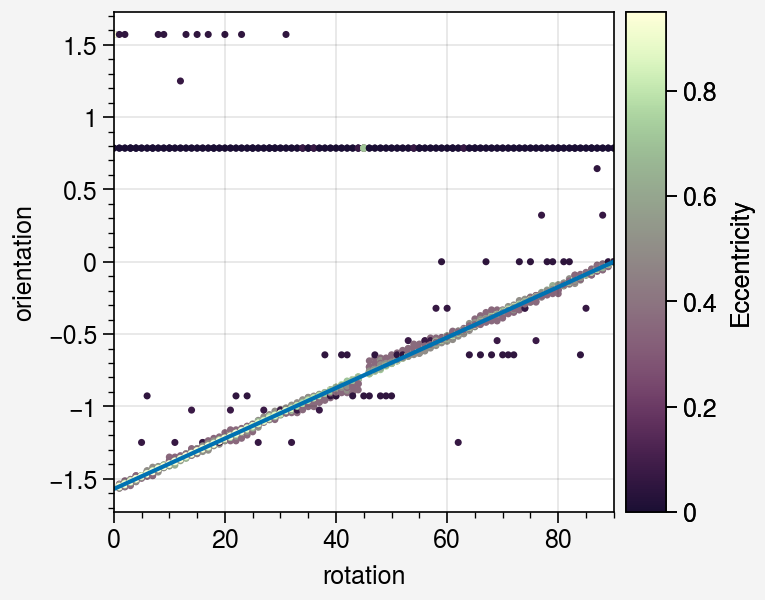

In [1091]:
fig, ax = pplt.subplots()
c = ax.scatter(props_all.loc[props_all.area > 1000, 'rotation'], props_all.loc[props_all.area > 1000, 'orientation'],
           marker='.', ms=15, c=props_all.loc[props_all.area > 1000, 'eccentricity'], cmap='tokyo')
ax.colorbar(c, label='Eccentricity')
ax.plot([0, 90], [-np.pi/2, 0])

For this first experiment, we can look into the accuracy of the orientation

In [1065]:
len(images)

91

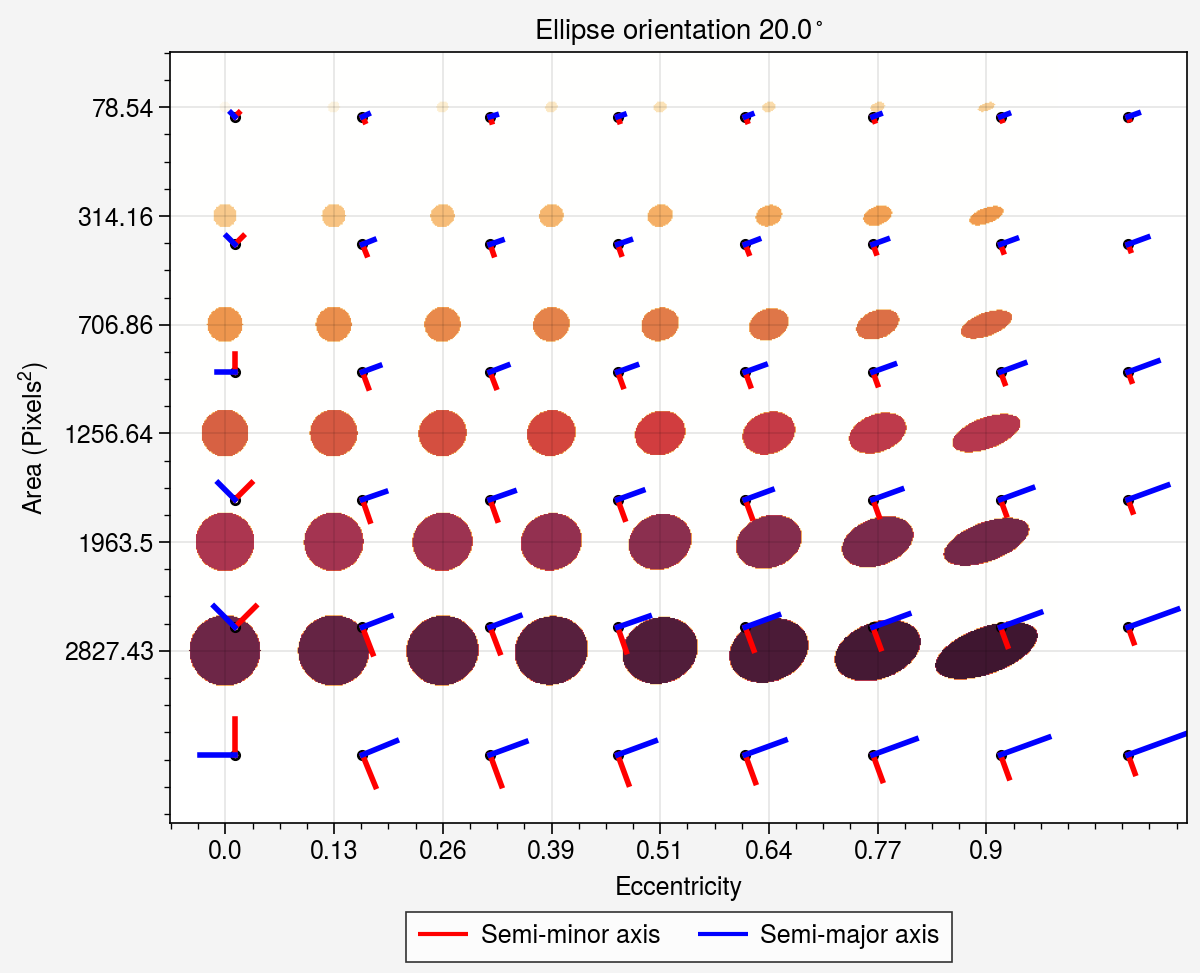

In [1092]:
import math
medians = df_results.groupby("ID").median()
fig, ax = pplt.subplots(width=6)
idx = 20
ax.imshow(skimage.measure.label(images[idx]))
for row, data in props[idx].iterrows():
    ax.plot(data['col_centroid'], data['row_centroid'], marker='.', color='w', edgecolor='k')

    y0, x0 = data['row_centroid'], data['col_centroid']
    orientation = data['orientation']
    x1 = x0 + math.cos(orientation) * 0.5 * data['axis_minor_length']
    y1 = y0 - math.sin(orientation) * 0.5 * data['axis_minor_length']
    x2 = x0 - math.sin(orientation) * 0.5 * data['axis_major_length']
    y2 = y0 - math.cos(orientation) * 0.5 * data['axis_major_length']

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2)
    ax.plot((x0, x2), (y0, y2), '-b', linewidth=2)
h = [ax.plot([],[],c=c) for c in ['r', 'b']]
ax.legend(h, ['Semi-minor axis', 'Semi-major axis'], loc='b')
ax.format(xreverse=False, yreverse=True, title='Ellipse orientation ' + str(props[idx]['rotation'].median()) + '$^\circ$',
         xlabel='Eccentricity', ylabel='Area (Pixels$^2$)', ylocator=ri, xlocator=ci,
         yformatter=[str(np.round(x, 2)) for x in A], xformatter=[str(np.round(x, 2)) for x in E])
fig.save("../figures/ellipse_test_" + str(idx) + ".png", dpi=300)

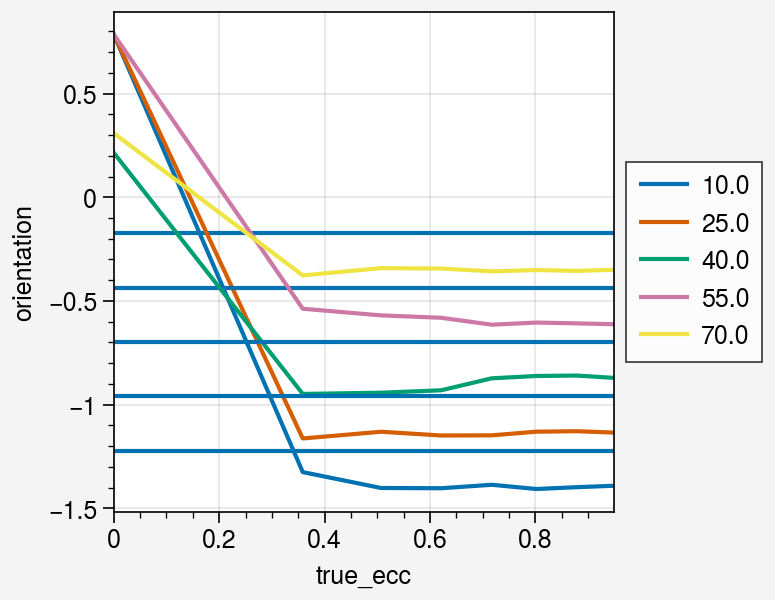

In [1081]:
fig, ax = pplt.subplots()
for idx in range(10, 80, 15):
    rot = props[idx]['rotation'].mean()
    ax.plot(props[idx].groupby('true_ecc').mean()['orientation'], label=rot)
    ax.axhline(-np.deg2rad(rot))
ax.legend(loc='r', ncols=1)

<a list of 1 Line2D objects>

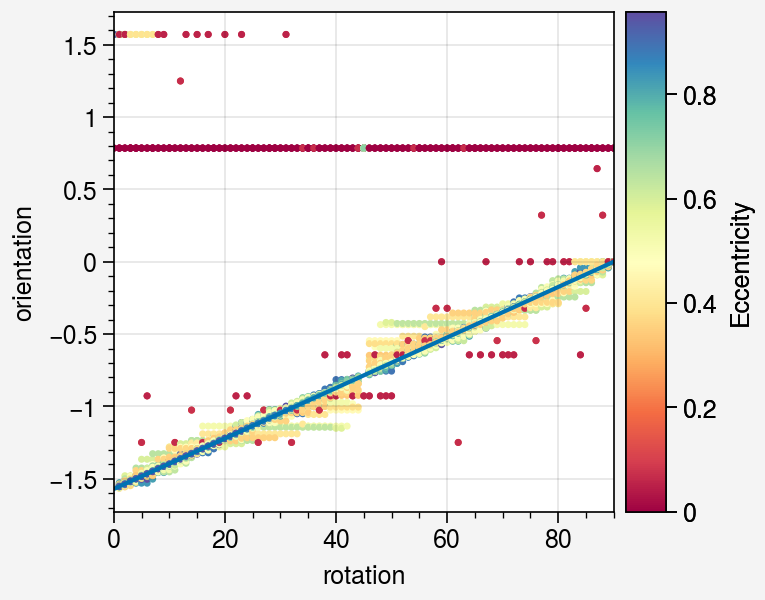

In [1054]:
fig, ax = pplt.subplots()
c = ax.scatter(props_all['rotation'], props_all['orientation'],
           marker='.', ms=15, c=props_all['eccentricity'], cmap='spectral')
ax.colorbar(c, label='Eccentricity')
ax.plot([0, 90], [-np.pi/2, 0])

In [777]:
np.rad2deg(props_all.loc[props_all.eccentricity==0, 'orientation'])
# Default is pi/4 if the major and minor axis are the same length

0       45.0
8       45.0
24      45.0
32      45.0
48      45.0
        ... 
4311    45.0
4327    45.0
4335    45.0
4351    45.0
4359    45.0
Name: orientation, Length: 394, dtype: float64

In [754]:
props_all = pd.concat(props, axis=0).reset_index(drop=True)
props_all['rel_err_area'] = (props_all['true_area'] - props_all['area'])/props_all['true_area']
props_all['rel_err_maj'] = (props_all['true_axis_major_length'] - props_all['axis_major_length'])/props_all['true_axis_major_length']
props_all['rel_err_min'] = (props_all['true_axis_minor_length'] - props_all['axis_major_length'])/props_all['true_axis_major_length']
props_all['rel_err_per'] = (props_all['true_perimeter'] - props_all['perimeter'])/props_all['true_perimeter']

results = props_all.groupby(['true_ecc', 'rotation']).std()

In [631]:
df_row_means = props[angle].groupby("true_row_center").mean()
df_row_stdev = props[angle].groupby("true_row_center").std()
df_row_means.index = A
df_row_stdev.index = A

In [632]:
df_row_means

,area,row_centroid,col_centroid,orientation,axis_major_length,axis_minor_length,eccentricity,true_col_center,true_area,true_ecc,true_axis_minor_length,true_axis_major_length
78.539816,77.75,54.0,432.0,0.098175,12.475498,8.168442,0.627056,432.0,78.539816,0.604079,8.30191,12.447077
314.159265,313.25,162.0,432.0,0.098175,24.909657,16.532182,0.609976,432.0,314.159265,0.604079,16.60382,24.894153
706.858347,707.50,270.0,432.0,0.000000,37.269665,24.948335,0.618195,432.0,706.858347,0.604079,24.90573,37.341230
1256.637061,1255.75,378.0,432.0,0.098175,49.696499,33.227202,0.602624,432.0,1256.637061,0.604079,33.20764,49.788306
1963.495408,1962.75,486.0,432.0,0.098175,62.228673,41.503952,0.603853,432.0,1963.495408,0.604079,41.50955,62.235383
2827.433388,2821.25,594.0,432.0,0.000000,74.633073,49.737547,0.613425,432.0,2827.433388,0.604079,49.81146,74.682460


In [537]:
df_props.rename({'centroid-0': 'row_centroid',
                 'centroid-1': 'col_centroid'}, axis=1, inplace=True)

In [538]:
df_props['eccentricity'] = np.sqrt(1 - df_props['axis_minor_length']*2/df_props['axis_major_length']**2)

In [594]:
np.sqrt(1 - df_props['true_axis_minor_length']*2/df_props['true_axis_major_length']**2).unique()

array([0.77459667, 0.77779785, 0.78740421, 0.80344191, 0.82602148,
       0.85547744, 0.89272941, 0.94068421, 0.89442719, 0.89581513,
       0.9000015 , 0.90706089, 0.91714543, 0.93054867, 0.94788338,
       0.97079524, 0.93094934, 0.9318386 , 0.93452401, 0.93906317,
       0.94557064, 0.95426091, 0.96556819, 0.9806268 , 0.9486833 ,
       0.94933786, 0.95131559, 0.9546621 , 0.95946749, 0.96589876,
       0.97429023, 0.98550581, 0.9591663 , 0.95968427, 0.96124975,
       0.9639003 , 0.96770982, 0.97281464, 0.97948617, 0.98842165])

<a list of 1 Line2D objects>

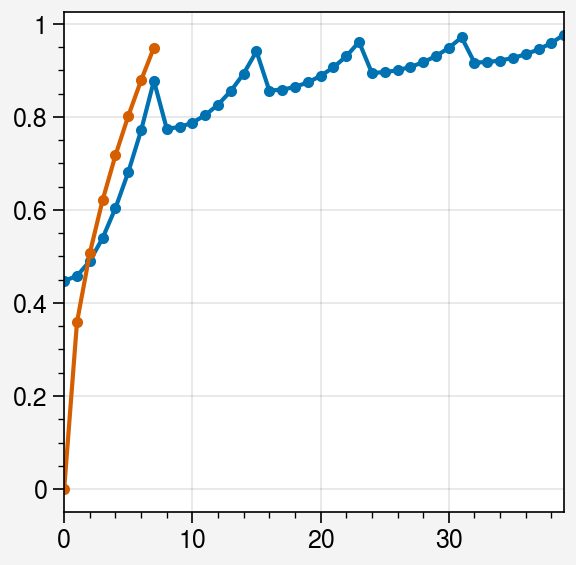

In [597]:
fig, ax = pplt.subplots()
ax.plot(np.sqrt(1 - (df_props['true_axis_minor_length']/2)*2/((df_props['true_axis_major_length']/2)**2)).unique(), marker='.')
ax.plot(E, marker='.')

In [581]:
E

array([0.        , 0.35856858, 0.50709255, 0.621059  , 0.71713717,
       0.80178373, 0.87831007, 0.9486833 ])

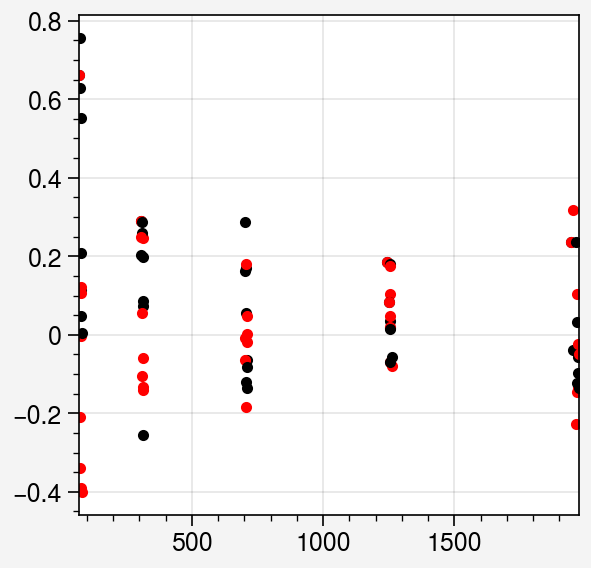

In [539]:
fig, ax = pplt.subplots()
for row, data in df_props.iterrows():
    ax.plot(data.area, data.true_axis_minor_length*2-data.axis_minor_length, marker='.', color='k')
    ax.plot(data.area, data.true_axis_major_length*2-data.axis_major_length, marker='.', color='r')

# Examining "trajectories"

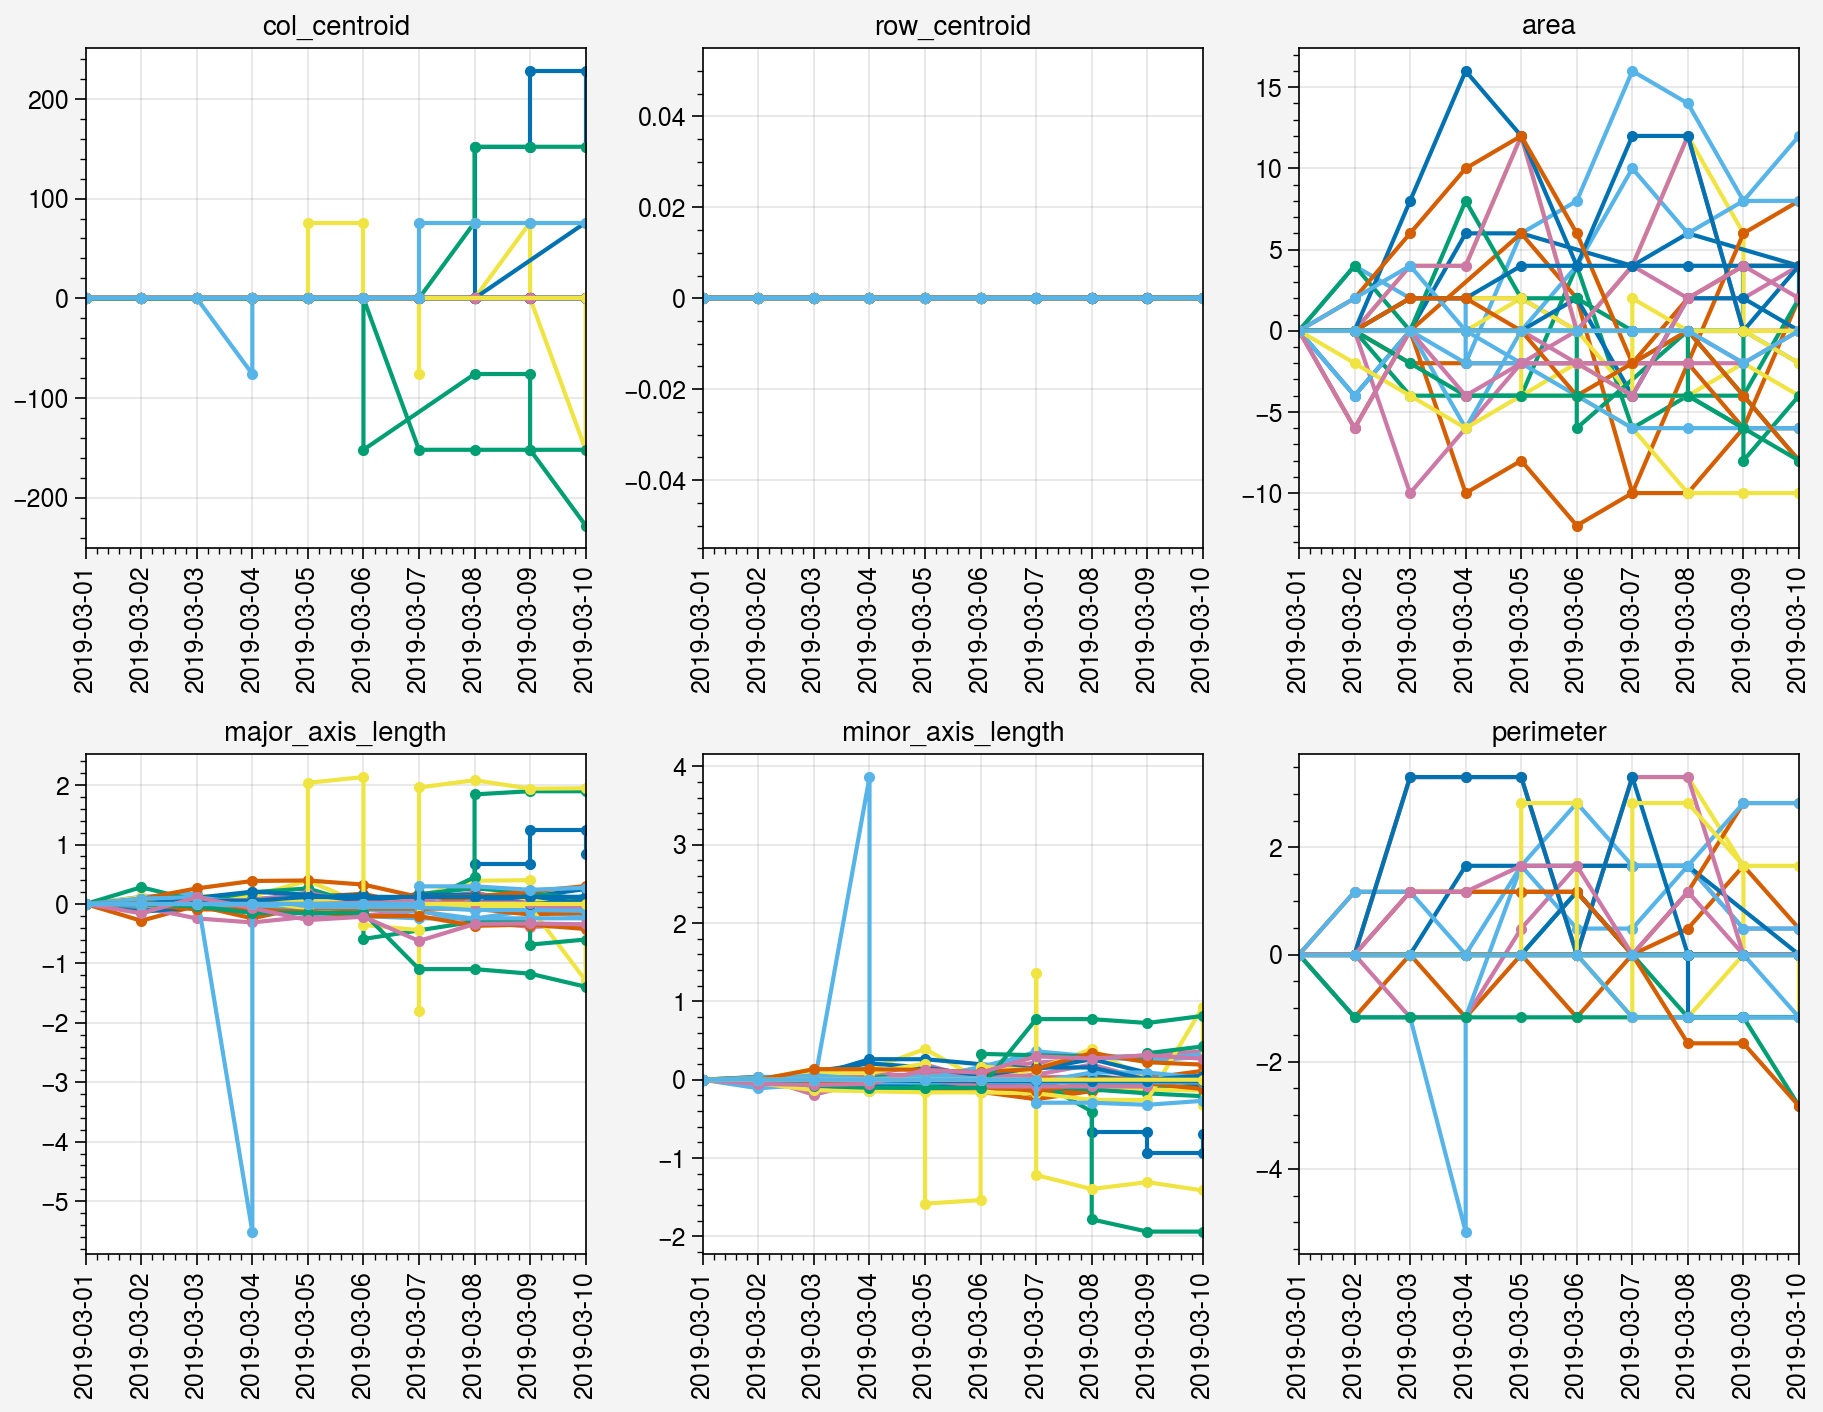

In [738]:
fig, axs = pplt.subplots(nrows=2, ncols=3, share=False)
for ax, var in zip(axs, ['col_centroid', 'row_centroid', 'area',
                         'major_axis_length', 'minor_axis_length', 'perimeter']):
    for name, group in df_results.groupby('ID'):
        ax.plot(group.passtime.values, (group[var] - group[var].values[0]).values, marker='.')
        ax.format(title=var)

ValueError: x and y must have same first dimension, but have shapes (11,) and (9,)

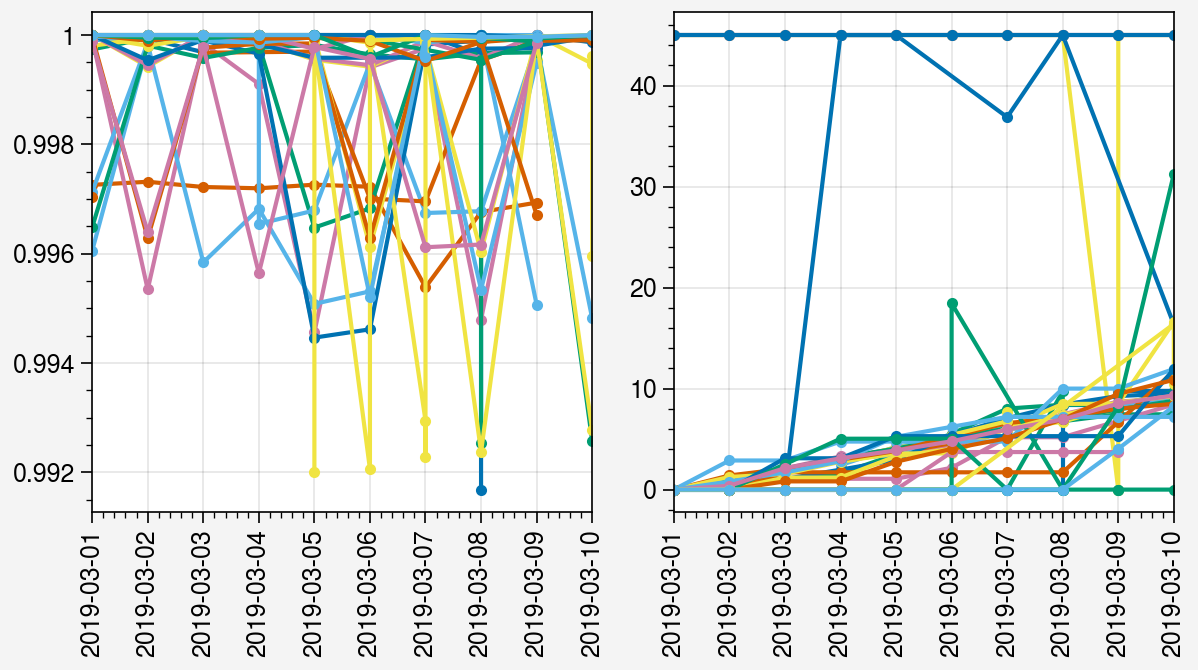

In [739]:
fig, axs = pplt.subplots(ncols=2, share=False)
for ax, var in zip(axs, ['corr', 'orientation']):
    for name, group in df_results.groupby('ID'):
        if var == 'orientation':
            data = (90 + np.rad2deg(group[var])) % 90
        else:
            data = group[var]
        ax.plot(group.passtime.values, data.values, marker='.')
axs[1].plot(group.passtime.values, np.arange(0, 9))
axs.format(toplabels=["Psi-s correlation", "Orientation"])

In [552]:
for name, group in df_results.groupby("ID"):
    print(name, len(group))
    if len(group) > 10:
        break
group.set_index('passtime')

1 13


,ID,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,area_mismatch,corr
passtime,,,,,,,,,,,,,,,
2019-03-01,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
2019-03-02,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
2019-03-03,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
2019-03-04,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
2019-03-05,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
2019-03-06,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
2019-03-07,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,NaN,NaN
2019-03-08,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,0.991685
2019-03-08,1,311.0,106,257,124,277,115,267,323.0,20.788838,19.041445,-1.425351,63.112698,0.0,1.000000


In [527]:
for name, group in df_results.groupby("ID"):
    if len(group) >= 10:
        break
group

,ID,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,area_mismatch,corr
0,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
1,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
2,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
3,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
4,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
5,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,1.000000
6,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,NaN,NaN
7,1,311.0,106,105,124,125,115,115,327.0,20.111586,19.708486,1.570796,64.284271,0.0,0.991685
8,1,311.0,106,257,124,277,115,267,323.0,20.788838,19.041445,-1.425351,63.112698,0.0,1.000000
9,1,311.0,106,257,124,277,115,267,323.0,20.788838,19.041445,-1.425351,63.112698,0.0,0.999871


# Simple case with more realistic shapes
To test the tracker, I'm setting up simple cases where there are known displacements and rotations.

In [808]:
import os
import proplot as pplt
import skimage
import pandas as pd

imloc = "/Users/dwatkin2/Documents/research/packages/IceFloeTracker.jl/test/test_inputs/tracker_rotation/"

files = [f for f in os.listdir(imloc) if 'png' in f]
files.sort()

In [964]:
images = [skimage.io.imread(imloc + f)[:,:] for f in files]

# for f, im in zip(files, images):
#     im[im > 0] = 255
#     skimage.io.imsave(imloc + f, im.astype('uint8'))

props = [pd.DataFrame(skimage.measure.regionprops_table(
    skimage.measure.label(im),
    properties=['area', 'centroid', 'orientation', 'perimeter',
    'axis_major_length', 'axis_minor_length'])) for im in images]


In [812]:
times = pd.date_range('2015-04-30', freq='1d', periods=6)
for idx in range(len(props)):
    props[idx]['passtime'] = times[idx]
props_df = pd.concat(props)

In [814]:
import numpy as np
props_df['orientation_degrees'] = np.rad2deg(props_df['orientation'])

In [823]:
np.diff(props_df.loc[1,['orientation_degrees']].values.squeeze())

array([-0.1704636 , -2.02196938, -6.04136541, -9.87606851,  5.01346322])

In [824]:
np.diff(props_df.loc[1,['centroid-0']].values.squeeze())

array([ -4.71808766, -10.09347644,   0.56716985,  -6.03455966,
        -4.76171982])

In [825]:
np.diff(props_df.loc[0,['centroid-0']].values.squeeze())

array([-4.2900783 , -9.93053361, -0.23130922, -5.29947924, -4.58224226])

In [830]:
np.diff(props_df.loc[1,['perimeter']].values.squeeze())

array([ 5.75735931, -4.10050506,  4.24264069, -1.27207794, -1.07106781])

In [834]:
props_df.iloc[0,:]

area                                 552.0
centroid-0                       106.48913
centroid-1                       53.813406
orientation                      -0.212525
perimeter                        99.355339
axis_major_length                38.508839
axis_minor_length                19.489579
passtime               2015-04-30 00:00:00
orientation_degrees             -12.176801
Name: 0, dtype: object

In [929]:
df = pd.DataFrame(skimage.measure.regionprops_table(
    skimage.measure.label(images[0]),
    properties=['area', 'centroid', 'orientation', 'perimeter',
    'axis_major_length', 'axis_minor_length', 'bbox']))

df.rename({'centroid-0': 'centroid_row',
           'centroid-1': 'centroid_col',
           'bbox-0': 'min_row',
           'bbox-1': 'min_col',
           'bbox-2': 'max_row',
           'bbox-3': 'max_col'}, axis=1, inplace=True)

Developing the set for verifying the rotation and displacement for IFT.

Starting from an image with well separated floes. One small, one large.



In [842]:
im2 = np.zeros(im.shape)
aft = skimage.transform.AffineTransform(rotation=5)
aft.estimate(im, im2)

False

In [853]:
import scipy.ndimage as si
# shift(image, shift=n)
df

,area,centroid-row,centroid-col,orientation,perimeter,axis_major_length,axis_minor_length,min_row,min_col,max_row,max_col
0,552.0,106.489130,53.813406,-0.212525,99.355339,38.508839,19.489579,91,44,128,66
1,1706.0,321.005275,110.093200,-0.505226,159.882251,57.299483,38.243086,295,90,347,134


In [1011]:
im = images[0].copy()
images_new = [im]

angle = [0, 1, 2, 5, 10, -5]
dx = [0, 0, -1, 4, 7, 5]
dy = [0, 5, 10, 0, 5, 5]

df_props = pd.DataFrame(skimage.measure.regionprops_table(
                            skimage.measure.label(im),
                properties=['centroid', 'bbox']))
df_props.rename({'centroid-0': 'centroid_row',
               'centroid-1': 'centroid_col',
               'bbox-0': 'min_row',
               'bbox-1': 'min_col',
               'bbox-2': 'max_row',
               'bbox-3': 'max_col'}, axis=1, inplace=True)
print(df_props)

for idx in range(1, len(angle)):
    # First shift the location of the centroids
    im_new = si.shift(images_new[idx - 1], shift=dy[idx], order=0)
    # im_new[im_new > 0] = 1
    # Then get the locations for the rotation
    df_props = pd.DataFrame(skimage.measure.regionprops_table(
                            skimage.measure.label(im_new),
                properties=['centroid', 'bbox', 'orientation']))
    df_props.rename({'centroid-0': 'centroid_row',
               'centroid-1': 'centroid_col',
               'bbox-0': 'min_row',
               'bbox-1': 'min_col',
               'bbox-2': 'max_row',
               'bbox-3': 'max_col'}, axis=1, inplace=True)
    print(df_props)
    # Then, we'll rotate those locations in place
    for row, data in df_props.iterrows():
        # initialize images
        rmin = data.min_row
        rmax = data.max_row
        cmin = data.min_col
        cmax = data.max_col
        r0 = data.centroid_row
        c0 = data.centroid_col

        margin = 40
        dr = max(abs(r0 - rmax), abs(r0 - rmin))
        dc = max(abs(c0 - cmax), abs(c0 - cmin))
        d = max(dr, dc) + margin
        print(d)
        rmin = int(np.floor(r0 - d))
        rmax = int(np.ceil(r0 + d))
        cmin = int(np.floor(c0 - d))
        cmax = int(np.ceil(c0 + d))
                

        im_new_temp = im_new.copy()
        
        im_new_temp[rmin:rmax, cmin:cmax] = 0
        im_new_temp[rmin:rmax, cmin:cmax] = si.rotate(im_new[rmin:rmax, cmin:cmax],
                                                angle=10, reshape=False, order=0)
    images_new.append(si.rotate(im_new,
                                angle=2, reshape=False, order=0,
                                ))
    

   centroid_row  centroid_col  min_row  min_col  max_row  max_col
0    106.489130     53.813406       91       44      128       66
1    321.005275    110.093200      295       90      347      134
   centroid_row  centroid_col  min_row  min_col  max_row  max_col  orientation
0    111.489130     58.813406       96       49      133       71    -0.212525
1    326.005275    115.093200      300       95      352      139    -0.505226
61.51086956521739
66.00527549824147
   centroid_row  centroid_col  min_row  min_col  max_row  max_col  orientation
0    126.489130     65.885870      111       56      148       78    -0.186198
1    338.835287    129.572098      312      110      365      153    -0.472902
61.51086956521739
66.83528722157092
   centroid_row  centroid_col  min_row  min_col  max_row  max_col  orientation
0    131.364791     63.375681      115       53      153       75    -0.137111
1    341.201760    134.470968      314      115      368      158    -0.434600
61.63520871143376
6

/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


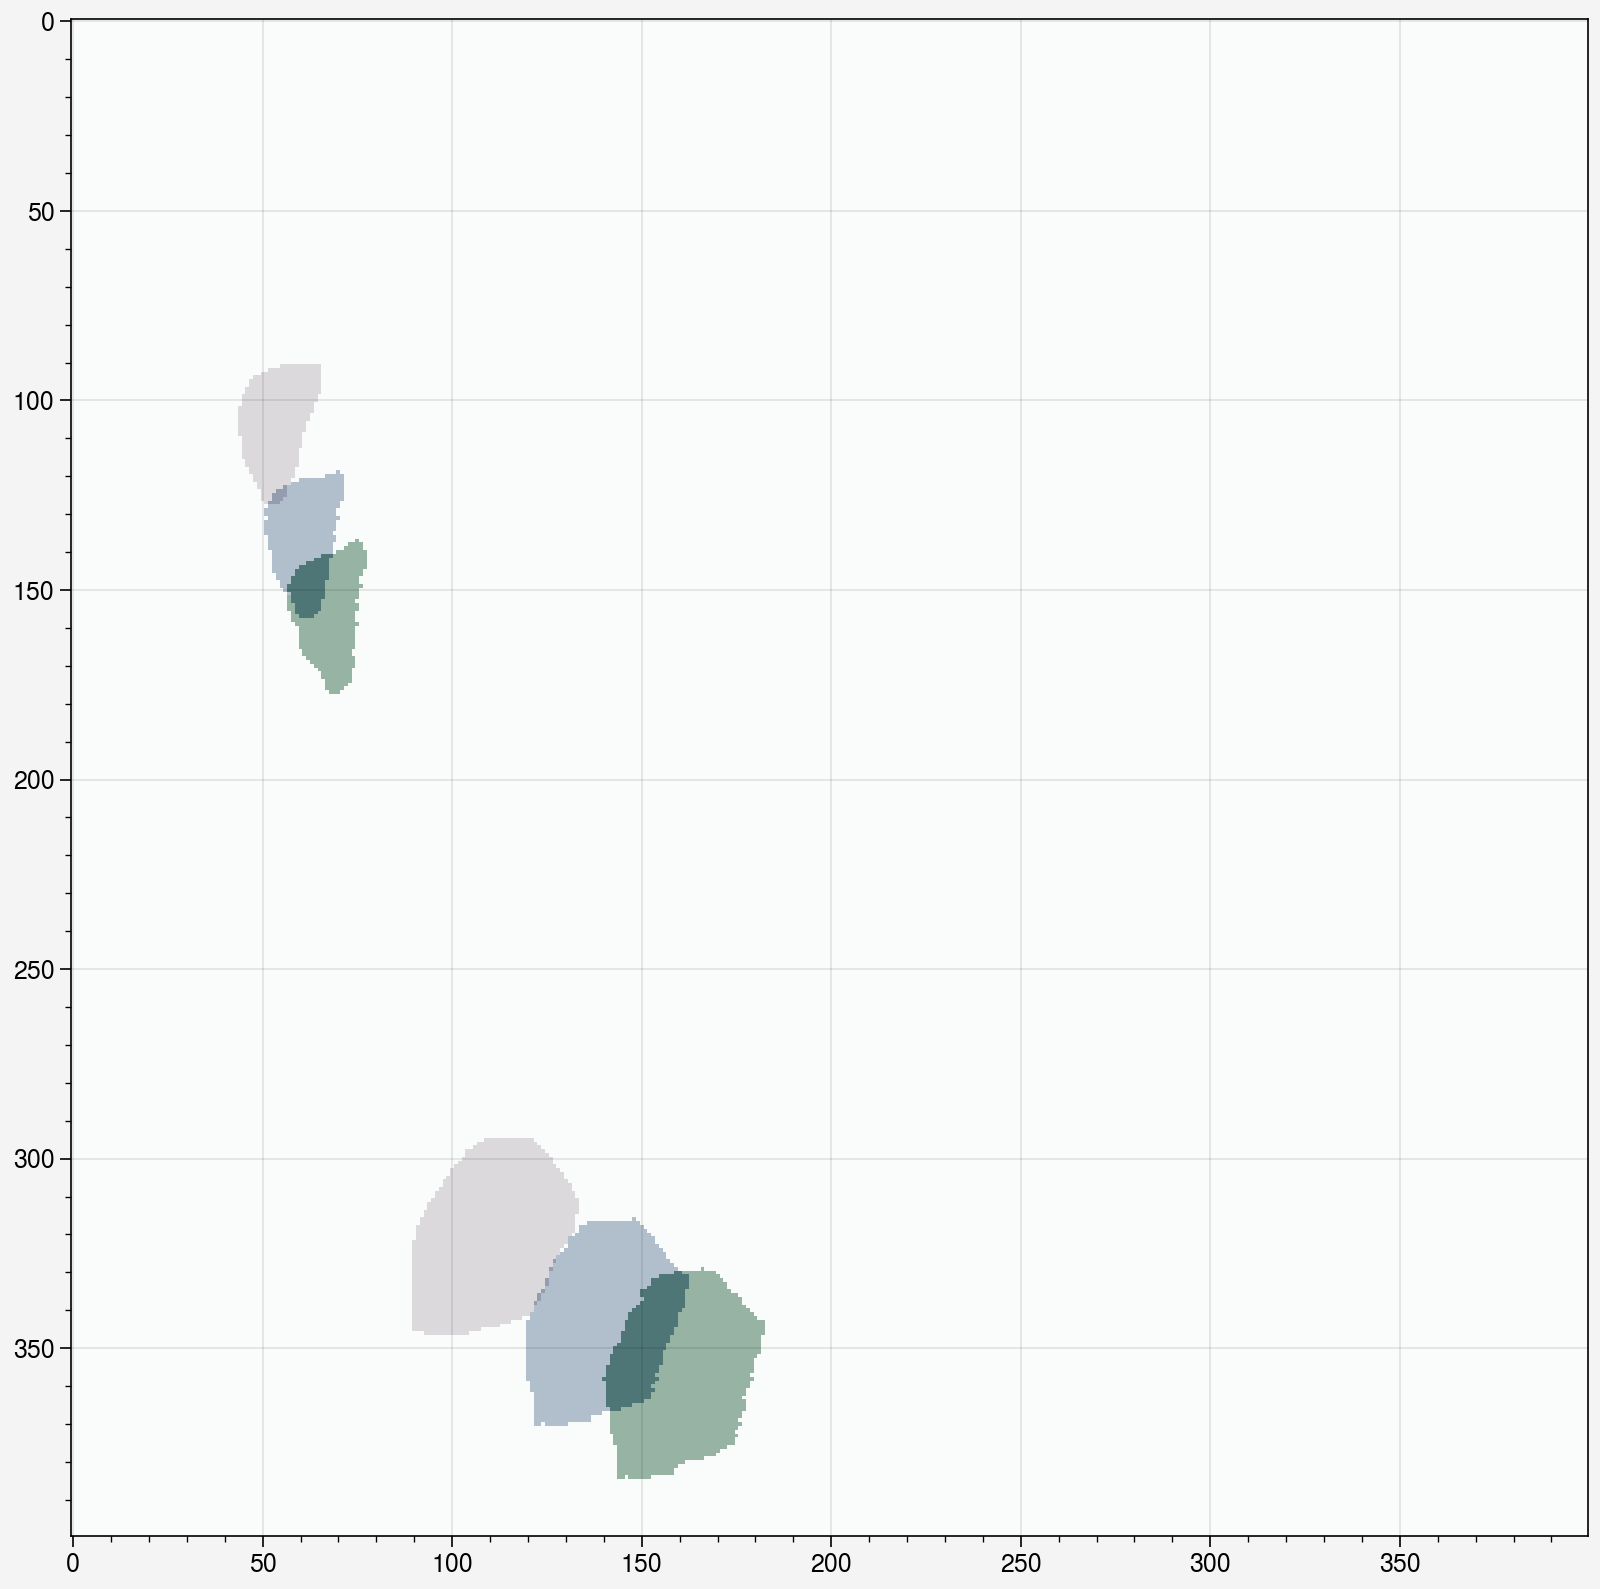

In [1012]:
fig, ax = pplt.subplots(width=8)
ax.imshow(images_new[0], alpha=0.5)
ax.imshow(images_new[3], alpha=0.5, cmap='blues')
ax.imshow(images_new[5], alpha=0.4, cmap='greens')


In [984]:
si.rotate(im[cmin:cmax, rmin:rmax], angle=5, reshape=False).shape

(65, 65)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)